# Downloading Dataset

Link: https://www.kaggle.com/datasets/roopahegde/cryptocurrency-timeseries-2020

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d roopahegde/cryptocurrency-timeseries-2020

Saving kaggle (2).json to kaggle (2).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/roopahegde/cryptocurrency-timeseries-2020
License(s): CC0-1.0
 97% 22.0M/22.7M [00:02<00:00, 15.4MB/s]
100% 22.7M/22.7M [00:02<00:00, 10.5MB/s]


# Importing necessary libraries

In [3]:
!unzip /content/cryptocurrency-timeseries-2020.zip

Archive:  /content/cryptocurrency-timeseries-2020.zip
  inflating: gemini_BTCUSD_2020_1min.csv  
  inflating: gemini_ETHUSD_2020_1min.csv  
  inflating: gemini_LTCUSD_2020_1min.csv  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# Loading data into DataFrame and analysis of it

In [4]:
bitcoin_df = pd.read_csv('/content/gemini_BTCUSD_2020_1min.csv')

In [8]:
bitcoin_df.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1.618880e+12,4/20/2021 0:02,BTCUSD,55717.47,55723.00,55541.69,55541.69,2.406734
1,1.618880e+12,4/20/2021 0:01,BTCUSD,55768.94,55849.82,55711.74,55717.47,0.573458
2,1.618880e+12,4/20/2021 0:00,BTCUSD,55691.79,55793.15,55691.79,55768.94,3.309904
3,1.618880e+12,4/19/2021 23:59,BTCUSD,55777.86,55777.86,55677.92,55691.79,0.684934
4,1.618880e+12,4/19/2021 23:58,BTCUSD,55803.50,55823.88,55773.08,55777.86,0.477225


In [7]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658065 entries, 0 to 658064
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unix Timestamp  658065 non-null  float64
 1   Date            658065 non-null  object 
 2   Symbol          658065 non-null  object 
 3   Open            658065 non-null  float64
 4   High            658065 non-null  float64
 5   Low             658065 non-null  float64
 6   Close           658065 non-null  float64
 7   Volume          658065 non-null  float64
dtypes: float64(6), object(2)
memory usage: 40.2+ MB


In [10]:
bitcoin_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unix Timestamp,658065.0,1.598615e+12,1.188579e+10,1.577840e+12,1.588310e+12,1.598790e+12,1.609000e+12,1.618880e+12
Open,658065.0,1.981606e+04,1.673763e+04,3.935290e+03,9.177940e+03,1.093611e+04,2.574149e+04,6.489000e+04
High,658065.0,1.982875e+04,1.675079e+04,3.939260e+03,9.180000e+03,1.093921e+04,2.575515e+04,6.490000e+04
Low,658065.0,1.980308e+04,1.672351e+04,3.901250e+03,9.176310e+03,1.093298e+04,2.572410e+04,6.477562e+04
Close,658065.0,1.981613e+04,1.673768e+04,3.935290e+03,9.177940e+03,1.093615e+04,2.574316e+04,6.489000e+04
Volume,658065.0,1.552492e+00,6.235548e+00,0.000000e+00,2.216175e-02,1.897123e-01,1.023481e+00,1.043580e+03


In [11]:
bitcoin_df.index = pd.to_datetime(bitcoin_df['Date'])
bitcoin_df.drop('Date',axis=1,inplace=True)


In [12]:
bitcoin_df.sort_index(inplace=True)

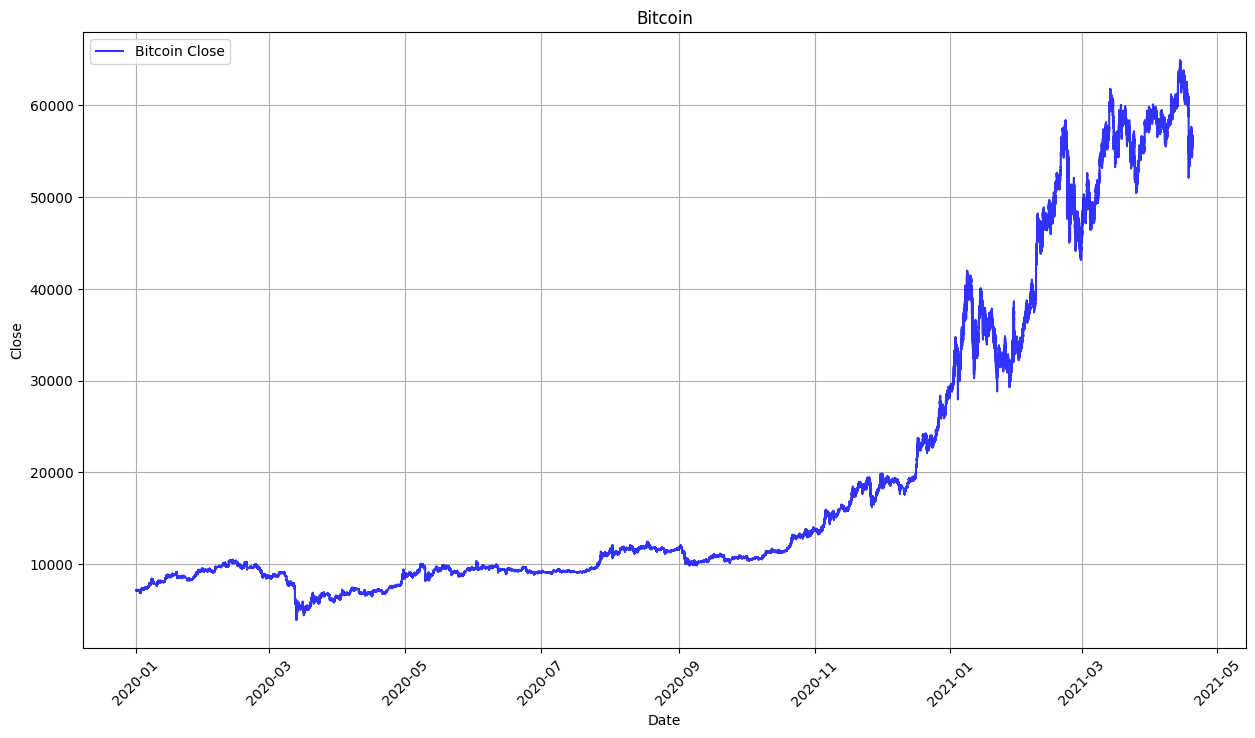

In [14]:
fig,axs = plt.subplots(1,1,figsize=(15, 8))
axs.plot(bitcoin_df.index,bitcoin_df['Close'],alpha=0.8, label='Bitcoin Close',color = 'b')

axs.grid(True)
axs.legend(loc="best")
axs.set_title('Bitcoin')
axs.set_xlabel('Date')
axs.set_ylabel('Close')
axs.tick_params(axis='x', rotation=45)
plt.show()

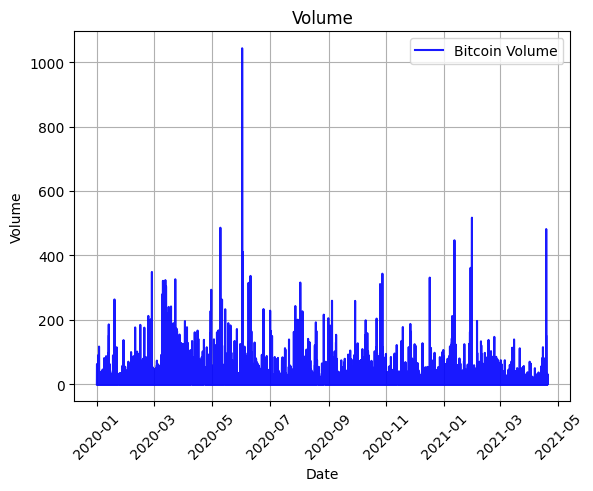

In [15]:
plt.plot(bitcoin_df.index,bitcoin_df['Volume'],alpha=0.9, label='Bitcoin Volume',color = 'b')

plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc="best")
plt.title('Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

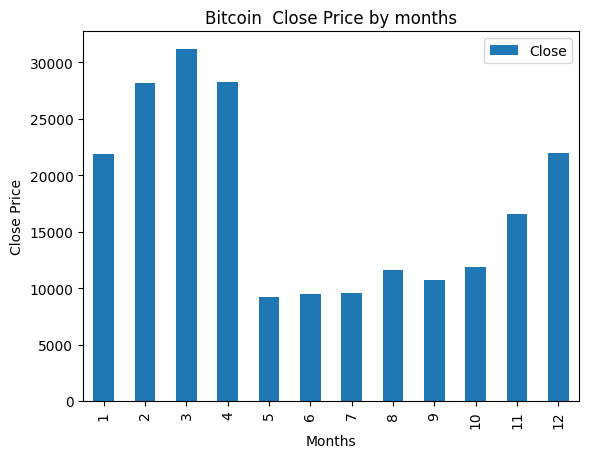

In [16]:
pd.DataFrame(bitcoin_df.groupby(bitcoin_df.index.month)['Close'].mean()).plot(kind='bar')
plt.title('Bitcoin  Close Price by months')
plt.xlabel('Months')
plt.ylabel('Close Price')
plt.show()

# Preparing Data for Neural Network model

In [17]:
df = bitcoin_df[['Close']]
df.head()

,Close
Date,
2020-01-01 00:00:00,7163.3
2020-01-01 00:01:00,7163.3
2020-01-01 00:02:00,7163.0
2020-01-01 00:03:00,7163.6
2020-01-01 00:04:00,7163.0


In [75]:
indexes = df.index

In [18]:
# time-delayed copies of the 'Close' column
def create_features(dataframe,window_size):

    for win in range(1, window_size+1):
        dataframe[f'Close_t-{win}'] = dataframe['Close'].shift(win)
    dataframe.dropna(inplace=True)
    return dataframe

In [21]:
# Each row will include 7 historical data points (Close_t-1 to Close_t-7) as new features.
df = create_features(df,7)

In [20]:
df

,Close,Close_t-1,Close_t-2,Close_t-3,Close_t-4,Close_t-5,Close_t-6,Close_t-7
Date,,,,,,,,
2020-01-01 00:07:00,7155.22,7155.23,7155.00,7163.00,7163.60,7163.00,7163.30,7163.30
2020-01-01 00:08:00,7155.74,7155.22,7155.23,7155.00,7163.00,7163.60,7163.00,7163.30
2020-01-01 00:09:00,7157.29,7155.74,7155.22,7155.23,7155.00,7163.00,7163.60,7163.00
2020-01-01 00:10:00,7157.79,7157.29,7155.74,7155.22,7155.23,7155.00,7163.00,7163.60
2020-01-01 00:11:00,7162.88,7157.79,7157.29,7155.74,7155.22,7155.23,7155.00,7163.00
...,...,...,...,...,...,...,...,...
2021-04-19 23:58:00,55777.86,55803.50,55690.64,55624.69,55651.82,55688.08,55749.28,55704.59
2021-04-19 23:59:00,55691.79,55777.86,55803.50,55690.64,55624.69,55651.82,55688.08,55749.28
2021-04-20 00:00:00,55768.94,55691.79,55777.86,55803.50,55690.64,55624.69,55651.82,55688.08


In [22]:
#scaling
scaler = MinMaxScaler((0,1))
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df),columns=scaler.get_feature_names_out())

In [23]:
#flipping
X = np.flip(df.drop('Close',axis=1).values,axis=1)
y = df['Close'].values

In [24]:
#train, test, val split and adding an axis because of LSTM need
train_len = int(0.8*len(X))
test_len = int(0.1*len(X))

X_train = np.expand_dims(X[:train_len],axis=-1)
X_test = np.expand_dims(X[train_len:train_len+test_len],axis=-1)
X_val = np.expand_dims(X[train_len+test_len:],axis=-1)

y_train = np.expand_dims(y[:train_len],axis=-1)
y_test = np.expand_dims(y[train_len:train_len+test_len],axis=-1)
y_val = np.expand_dims(y[train_len+test_len:],axis=-1)

In [25]:
X_train.shape,X_test.shape,X_val.shape,y_train.shape,y_test.shape,y_val.shape

((526440, 7, 1),
 (65805, 7, 1),
 (65806, 7, 1),
 (526440, 1),
 (65805, 1),
 (65806, 1))

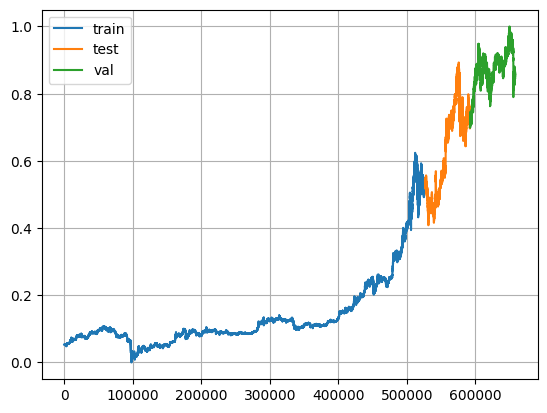

In [26]:
plt.plot(indexes[:train_len],y_train,label='train')
plt.plot(indexes[train_len:train_len+test_len],y_test, label='test')
plt.plot(indexes[train_len+test_len:],y_val,label='val')

plt.legend()
plt.grid(True)
plt.show()

In [27]:
#converting into torch tensors
X_train = torch.tensor(X_train.copy(),dtype=torch.float32)
X_test = torch.tensor(X_test.copy(),dtype=torch.float32)
X_val = torch.tensor(X_val.copy(),dtype=torch.float32)

y_train = torch.tensor(y_train.copy(),dtype=torch.float32)
y_test = torch.tensor(y_test.copy(),dtype=torch.float32)
y_val = torch.tensor(y_val.copy(),dtype=torch.float32)

In [28]:
X_train.shape,X_test.shape,X_val.shape,y_train.shape,y_test.shape,y_val.shape

(torch.Size([526440, 7, 1]),
 torch.Size([65805, 7, 1]),
 torch.Size([65806, 7, 1]),
 torch.Size([526440, 1]),
 torch.Size([65805, 1]),
 torch.Size([65806, 1]))

# Creating Torch datasets and dataloaders

In [29]:
# Creating torch dataset
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(TimeSeriesDataset,self).__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

In [30]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
val_dataset = TimeSeriesDataset(X_val,y_val)

In [31]:
train_dataloader = DataLoader(train_dataset, batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32,shuffle=False)
val_dataloader = DataLoader(val_dataset,batch_size = 32,shuffle=False)

# Selecting device and building Model

In [32]:
#device will be gpu if avaliable else cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
# Model
class Model(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 16, stacked_lstm = 1):
      super(Model,self).__init__()
      self.hidden_size = hidden_size
      self.stacked_lstm = stacked_lstm

      self.lstm = nn.LSTM(input_size,hidden_size,stacked_lstm,batch_first=True)
      self.linear = nn.Linear(hidden_size,1)

    def forward(self,sequence):

      batch_size = sequence.size(0)

      h0 = torch.zeros(self.stacked_lstm,batch_size,self.hidden_size).to(device)
      c0 = torch.zeros(self.stacked_lstm,batch_size,self.hidden_size).to(device)

      output,_ = self.lstm(sequence,(h0,c0))
      output = self.linear(output[:,-1,:])

      return output



#Initialization of Model

In [41]:
input_size = X_train.shape[2]
hidden_size = 4
n_stacked_lstm = 1
model = Model(input_size,hidden_size,n_stacked_lstm).to(device)

# Train Loop

In [42]:
optimizer = torch.optim.SGD(model.parameters(),lr=3e-4)
epochs = 50
criterion = nn.MSELoss().to(device)
train_losses = []
test_losses = []

for epoch in range(epochs):
  train_loss = 0
  test_loss = 0
  model.train()
  dlc = 0
  for x,y in train_dataloader:
    x = x.to(device)
    y = y.to(device)

    y_pred = model(x).to(device)


    loss = criterion(y,y_pred)
    if torch.isnan(loss):
      print('loss is empty!')
      continue
    else:

      train_loss += loss.item()
      dlc += 1
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= dlc
  train_losses.append(train_loss)


  dlc = 0
  # model.train(False)
  model.eval()
  with torch.inference_mode():

    for x,y in val_dataloader:
      x = x.to(device)
      y = y.to(device)

      val_pred = model(x)
      loss = criterion(y,val_pred)
      if torch.isnan(loss):
        print('loss is empty!')
        continue
      else:

        test_loss += loss.item()
        dlc += 1
    test_loss /= dlc
    test_losses.append(test_loss)

  print(f"epoch: {epoch+1} | train loss: {train_loss:.8f} | test loss: {test_loss:.8f}")


epoch: 1 | train loss: 0.01259356 | test loss: 0.45601788
epoch: 2 | train loss: 0.01008510 | test loss: 0.44270803
epoch: 3 | train loss: 0.00976398 | test loss: 0.42869958
epoch: 4 | train loss: 0.00941147 | test loss: 0.41374466
epoch: 5 | train loss: 0.00901652 | test loss: 0.39601918
epoch: 6 | train loss: 0.00857107 | test loss: 0.37699667
epoch: 7 | train loss: 0.00806167 | test loss: 0.35537720
epoch: 8 | train loss: 0.00747562 | test loss: 0.32965216
epoch: 9 | train loss: 0.00679868 | test loss: 0.30108776
epoch: 10 | train loss: 0.00602667 | test loss: 0.26757458
epoch: 11 | train loss: 0.00516513 | test loss: 0.23266990
epoch: 12 | train loss: 0.00423968 | test loss: 0.19465636
epoch: 13 | train loss: 0.00329789 | test loss: 0.15782117
epoch: 14 | train loss: 0.00240449 | test loss: 0.12387303
epoch: 15 | train loss: 0.00162787 | test loss: 0.09515182
epoch: 16 | train loss: 0.00101832 | test loss: 0.07273638
epoch: 17 | train loss: 0.00058993 | test loss: 0.05620849
epoch:

# Performance of model

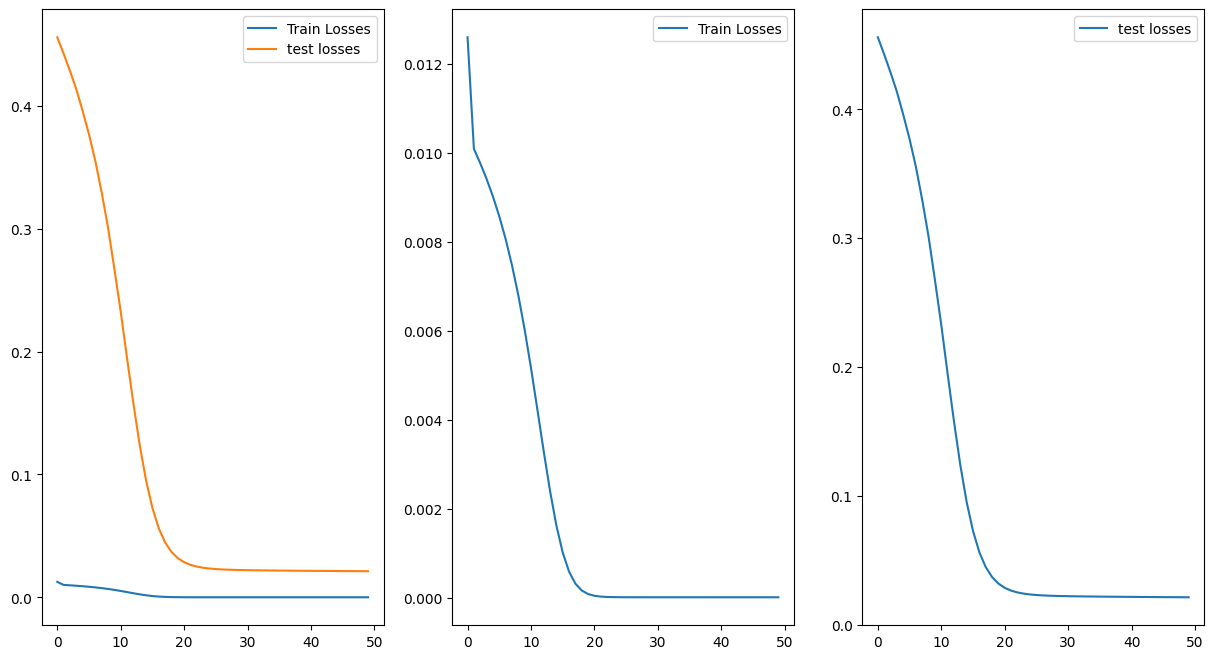

In [43]:
fig,axis = plt.subplots(1,3,figsize=(15, 8))
axis[0].plot(train_losses,label = 'Train Losses')
axis[0].plot(test_losses, label = 'test losses')

axis[1].plot(train_losses,label = 'Train Losses')
axis[2].plot(test_losses, label = 'test losses')


axis[0].legend(loc='best')
axis[1].legend(loc='best')
axis[2].legend(loc='best')
plt.show()

#Saving model

In [84]:
torch.save(model.state_dict(),'/content/time_series.pth')

# Making predictions

In [ ]:
torch.tensor(X_test.values).shape

torch.Size([98710, 8])

In [ ]:
torch.tensor(X_test.values).to(device)[:32].shape

torch.Size([32, 8])

In [51]:
model.eval()
preds = []
with torch.inference_mode():
  for i,_ in test_dataloader:
    i = i.to(device)
    pred = model(i)
    preds.append(pred)




In [50]:
len(test_dataloader)

2057

In [54]:
len(X_test)

65805

In [61]:
real_preds_test_set = [float(j) for i in preds for j in i]

In [70]:
test_pred_df = pd.DataFrame({'real':y_test.squeeze(),'preds':real_preds_test_set})

# Plotting predictions

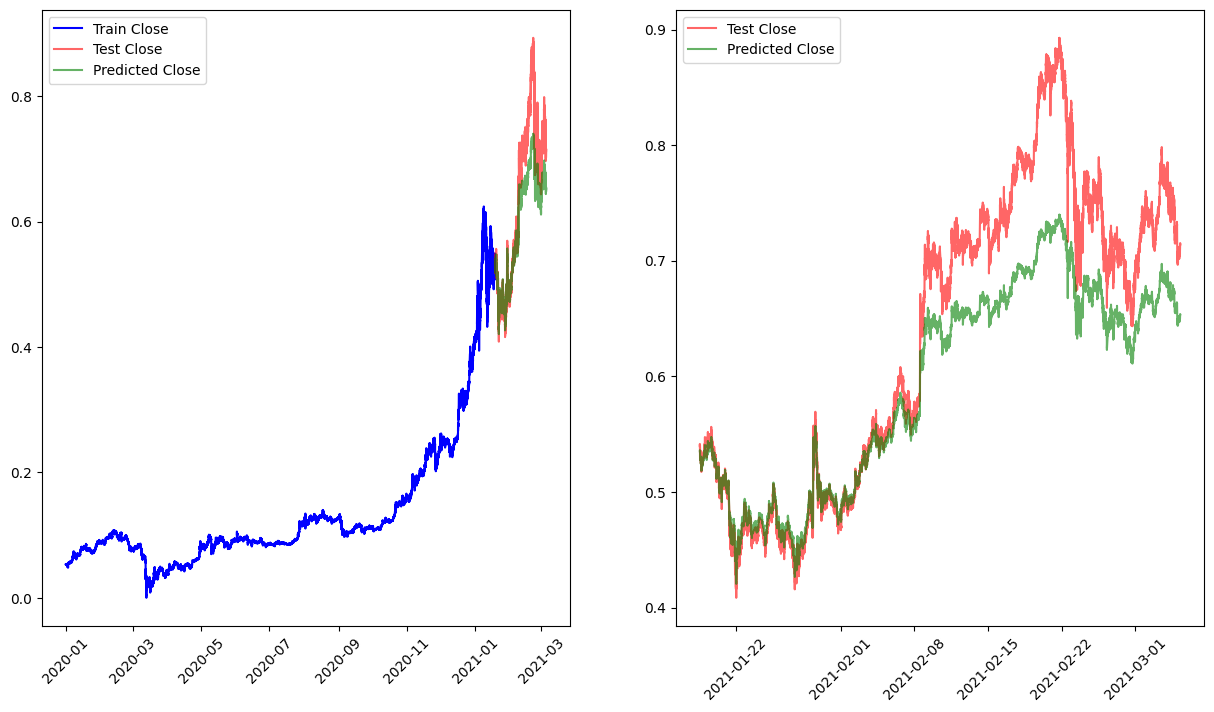

In [83]:
fig, axis = plt.subplots(1,2,figsize= (15,8))
axis[0].plot(indexes[:train_len], y_train.squeeze(), label='Train Close', color='b')
axis[0].plot(indexes[train_len:train_len+test_len],
             y_test.squeeze(),
             label='Test Close',
             color='r',
             alpha = 0.6)
axis[0].plot(indexes[train_len:train_len+test_len],
             real_preds_test_set,
             label='Predicted Close',
             color='g',
             alpha = 0.6)
axis[0].legend()
axis[0].tick_params(axis='x', rotation=45)


axis[1].plot(indexes[train_len:train_len+test_len],
             y_test.squeeze(),
             label='Test Close',
             color='r',
             alpha = 0.6)
axis[1].plot(indexes[train_len:train_len+test_len],
             real_preds_test_set,
             label='Predicted Close',
             color='g',
             alpha = 0.6)
axis[1].legend()
axis[1].tick_params(axis='x', rotation=45)
plt.show()